<a href="https://colab.research.google.com/github/dhavalsimaria/MachineLearning/blob/master/NITW/DL%20%26%20AI/Industry_Grade_Project_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Chatbot from Scratch 


##### In this project we will build a chatbot from scratch using the corenell University's Movie Dialogue corpus.
##### We will be using a deep learning based architecture with the main components as a lstm based encoder and decoder.

In [1]:
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from collections import Counter
import nltk
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
import keras
import nltk
import numpy
import sklearn

Please make sure that the version of the respective packages are met to the requirement. **I have commented out this code as versions used in colab currently are higher than mentioned. Same was confirmed with Edureka team earlier.**

In [3]:
'''assert keras.__version__=='2.1.2'
assert nltk.__version__=='3.4.1'
assert sklearn.__version__=='0.21.2'
assert numpy.__version__=='1.12.1'
'''

"assert keras.__version__=='2.1.2'\nassert nltk.__version__=='3.4.1'\nassert sklearn.__version__=='0.21.2'\nassert numpy.__version__=='1.12.1'\n"

Download the glove model available at https://nlp.stanford.edu/projects/glove/

Specification : Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip


you can download it with 'wget' or can directly put the embedding zip file inside 'embedding_data' folder and unzip it.

In [4]:
! curl -O http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1449M  100 1449M    0     0  2116k      0  0:11:41  0:11:41 --:--:-- 2790k


In [5]:
! unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


Download the Cornell Movie Dialog dataset

In [6]:
!curl -L -O http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9684k  100 9684k    0     0  2273k      0  0:00:04  0:00:04 --:--:-- 2273k


Unzip the Cornell Movie Dialog dataset

In [7]:
!unzip cornell_movie_dialogs_corpus.zip

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-dialogs corpus/movie_characters_metadata.txt  
  inflating: cornell movie-dialogs corpus/movie_conversations.txt  
  inflating: cornell movie-dialogs corpus/movie_lines.txt  
  inflating: cornell movie-dialogs corpus/movie_titles_metadata.txt  
  inflating: cornell movie-dialogs corpus/raw_script_urls.txt  
  inflating: cornell movie-dialogs corpus/README.txt  
  inflating: __MACOSX/cornell movie-dialogs corpus/._README.txt  


Define constants. **Some are modified based on folder structure in colab**

In [0]:
RAND_STATE=np.random.seed(42)
BATCH_SIZE = 32
NUM_EPOCHS = 10
GLOVE_EMBEDDING_SIZE = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 10000
DATA_SET_NAME = 'cornell'
#DATA_PATH = './cornell/movie_lines_cleaned.txt'
#GLOVE_MODEL = "./embedding_data/glove.twitter.27B.100d.txt"
DATA_PATH = 'cornell movie-dialogs corpus/movie_lines.txt'
GLOVE_MODEL = "glove.twitter.27B.100d.txt"
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
WEIGHT_FILE_PATH =  DATA_SET_NAME + '/word-glove-weights.h5'

Function to identify if a given word is whitelisted or not.

In [0]:
def in_white_list(_word):
  for char in _word:
        if char in WHITELIST:
            return True

  return False

Load the glove word embedding in to a dictionary where the **key** is a unique **word token** and the **value** is a **d** dimension vector 

# Test-1

In [0]:
def load_glove_vector():
    _word2embedding = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        values = line.split()
        word = values[0]
        #vector = np.asarray(values[1:], "float32")
        vector = np.array([float(val) for val in values[1:]])
        _word2embedding[word] = vector
    file.close()
    return _word2embedding

In [11]:
word2embedding = load_glove_vector()
len(word2embedding.keys())

1193514

# Check-1

Here assert statement to modified to have latest number of word2embeddings in glove model.

In [12]:
#assert len(word2embedding.keys())==1193513
assert len(word2embedding.keys())==1193514
for key in word2embedding.keys():
    try:
        assert len(word2embedding[key])==100
    except AssertionError:
        print (key,len(word2embedding[key]))     

-0.32053 99


# Data Preparation

In [0]:
target_counter = Counter()
lines = open(DATA_PATH, 'rt', encoding='latin1').read().split(' +++$+++ ')
input_texts = []
target_texts = []
prev_words = []

Import NLTK library to tokenize the lines in dataset.

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
for line in lines:
    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]
    if len(prev_words) > 0:
        input_texts.append(prev_words)
        target_words = next_words[:]
        target_words.insert(0, 'start')
        target_words.append('end')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)
    prev_words = next_words

Filter the conversations till max word length and convert the dialogues pairs into input text and target texts. Put **start** and **end** token to recognise the beginning and end of the sentence token.

## Let's see some of the training examples

In [16]:
for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
    if idx > 10:
        break
    print([input_words, target_words])

[['l1045'], ['start', 'u0', 'end']]
[['u0'], ['start', 'm0', 'end']]
[['m0'], ['start', 'bianca', 'end']]
[['bianca'], ['start', 'they', 'do', 'not', '!', 'l1044', 'end']]
[['they', 'do', 'not', '!', 'l1044'], ['start', 'u2', 'end']]
[['u2'], ['start', 'm0', 'end']]
[['m0'], ['start', 'cameron', 'end']]
[['cameron'], ['start', 'they', 'do', 'to', '!', 'l985', 'end']]
[['they', 'do', 'to', '!', 'l985'], ['start', 'u0', 'end']]
[['u0'], ['start', 'm0', 'end']]
[['m0'], ['start', 'bianca', 'end']]


Import **OS** library to create directory to hold the Cornell movie dialogue dataset.

In [0]:
import os
os.mkdir(DATA_SET_NAME)

### Create two dictionaries 
<ol>
<li>target_word2id
<li>target_id2word
</ol>
and save it as NumPy file format in the disk.
<p>
<strong>NOTE:</strong> The ids should start from 1 beacause <strong>0</strong> is reserved for <strong>'unknown'</strong> tokens.
Make sure you cosider only the <strong>most common</strong> tokens with <strong>MAX_VOCAB_SIZE</strong> defined above.

Most common refers to tokens with higher frequency. 
</p>
<strong>Help:</strong>
<ol>
<li>Use the target_counter which have the token counts.  
<li>Use target_counter.most_common(MAX_VOCAB_SIZE) to filter common tokens
    </ol>

In [0]:
target_word2idx = dict()

for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
  target_word2idx[word[0]] = idx + 1

''''if 'unknown' not in target_word2idx:
    target_word2idx['unknown'] = 0'''

target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_decoder_tokens = len(target_idx2word) + 1

np.save( DATA_SET_NAME + '/word-glove-target-word2idx.npy', target_word2idx)
np.save( DATA_SET_NAME + '/word-glove-target-idx2word.npy', target_idx2word)

# Check-2

In [19]:
print(len (target_word2idx.keys()))
print(len (target_idx2word.keys()))
print(MAX_VOCAB_SIZE+1)
#assert len (target_word2idx.keys())==len (target_idx2word.keys())==MAX_VOCAB_SIZE+1
assert len (target_word2idx.keys())==len (target_idx2word.keys())==MAX_VOCAB_SIZE

10000
10000
10001


# Prepare the input data with embedding
The input data is a list of lists 
<ol>
<li> First list is a list of sentences
<li> Each sentence is a list of words
 </ol>

In [20]:
input_texts_word2em = []
encoder_max_seq_length = 0
decoder_max_seq_length = 0

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
      
        embeddings = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
        if w in word2embedding:
          embeddings = word2embedding[w]
        encoder_input_wids.append(embeddings)


    input_texts_word2em.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print(context)
np.save( DATA_SET_NAME + '/word-glove-context.npy', context)

{'num_decoder_tokens': 10001, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


# Check-3

In [0]:
for input_text,input_text_embed in zip (input_texts,range(len(input_texts_word2em))):
    assert (len(input_text)==len(input_texts_word2em[input_text_embed]))

# Generate Training data per batch

generate_batch takes input embedding data (input_word2em_data) and target text data (target_texts) and returns trainable X and Y.
X is a list of [X1,X2]
where 
X1 is encoder_input_data_batch( which is created by putting the word embedding(glove vector) of the input tokens) padded in to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

X2 is decoder_input_data_batch which is created by putting the word embedding(glove vector) of the target_words tokens and padding it to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

Y is decoder_target_data_batch which is in shape of (BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens)
which signifies for each target token text  in the batch we have an option of any token from the vocabularu to be the next predicted word 

In [0]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            encoder_input_data_batch = pad_sequences(input_word2em_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
              for idx, w in enumerate(target_words):
                #w2idx = target_word2idx['unknown']
                if w in target_word2idx:
                  w2idx = target_word2idx[w]
                if w in word2embedding:
                  decoder_input_data_batch[lineIdx, idx, :] = word2embedding[w]
                if idx > 0:
                  decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

# Check-4

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)
train_gen = generate_batch(X_train, Y_train)
test_gen = generate_batch(X_test, Y_test)

for i,j in train_gen:
    assert i[0].shape==(BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert i[1].shape==(BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert j.shape==(BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])

print ('Test Case 4 Passes!')

Test Case 4 Passes!


# Test-5

<ol>
<li> Step 1: Use a LSTM encoder to get input words encoded in the form of (encoder outputs, encoder hidden state, encoder context) from input words
<li> Step 2:  Use a LSTM decoder to get target words encoded in the form of (decoder outputs, decoder hidden state, decoder context) from target words. Use encoder hidden states and encoder context (represents input memory) as initial state .
<li> Step 3: Use a dense layer to predict the next token out of the vocabulary given decoder output generated by Step 2.
<li> Step 4: Use loss ='categorical_crossentropy' and optimizer='rmsprop'
</ol>

In [24]:
encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
encoder_states = [encoder_state_h, encoder_state_c]

decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

json = model.to_json()
#open('models/' + DATA_SET_NAME + '/word-glove-architecture.json', 'w').write(json)
open(DATA_SET_NAME + '/word-glove-architecture.json', 'w').write(json)

'''
Here I have reduced the size by 1000th part to get a complete execution in Google Colab.
When I use entire X_train to fit the model, Google Colab gets disconnected after sometime without completing all the epochs.
'''
train_num_batches = len(X_train)/1000       
test_num_batches = len(X_test)/1000

checkpoint = ModelCheckpoint(filepath = WEIGHT_FILE_PATH, save_best_only=True)

model.fit_generator(generator=train_gen, steps_per_epoch = train_num_batches,
                    epochs = NUM_EPOCHS,
                    verbose = 1, validation_data = test_gen, 
                    validation_steps = test_num_batches,
                    callbacks = [checkpoint])

model.save_weights(WEIGHT_FILE_PATH)

Epoch 1/10
976/975 [==============================] - 212s 217ms/step - loss: 0.5862 - accuracy: 0.0381 - val_loss: 0.9607 - val_accuracy: 0.0413
Epoch 2/10
976/975 [==============================] - 206s 212ms/step - loss: 0.5391 - accuracy: 0.0431 - val_loss: 0.6677 - val_accuracy: 0.0436
Epoch 3/10
976/975 [==============================] - 206s 211ms/step - loss: 0.5207 - accuracy: 0.0446 - val_loss: 0.5647 - val_accuracy: 0.0451
Epoch 4/10
976/975 [==============================] - 205s 210ms/step - loss: 0.5194 - accuracy: 0.0452 - val_loss: 0.6502 - val_accuracy: 0.0452
Epoch 5/10
976/975 [==============================] - 208s 213ms/step - loss: 0.5164 - accuracy: 0.0460 - val_loss: 0.5078 - val_accuracy: 0.0460
Epoch 6/10
976/975 [==============================] - 206s 211ms/step - loss: 0.5087 - accuracy: 0.0462 - val_loss: 0.4130 - val_accuracy: 0.0474
Epoch 7/10
976/975 [==============================] - 206s 211ms/step - loss: 0.5042 - accuracy: 0.0463 - val_loss: 0.4220 -

# Model Architecture 

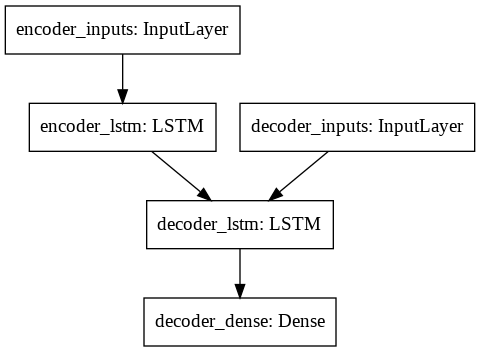

In [25]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png',height=400,width=400)

# The Model architecture is explined in the diagram above 

<ol>Riki chatbot Model Architecture can be summarized as follows:
<li> Initially, Encoder layer and Decoder layer are created w.r.t Glove embedding size.
<li> Encoder LSTM layer encodes the input words in the form of encoder outputs, encoder hidden states and encoder context.
<li> Using encoder hidden states and encoder context, Decoder LSTM creates target words in the form of decoder outputs, decoder hiddern states and decoder context.
<li> Finally a Dense layer uses the decoder output created in previous step
to predict next word in the vocabulary
</ol>

# Check-5 

Check the model summary should look like this 

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 100)    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 100)    0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 365568      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  365568      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]         

# Prediction

<ol>I have provided two ways to interact with Riki chatbot:
<li> Provide input statement/sentence to reply method of Riki chatbot.(Predict Manually)
<li> Use a basic user-interface to provide input statement/sentence
to Riki chatbot which internally calls it's reply() method to provide the output.(Predicting with interactive interface)
</ol>

In [0]:
class RikiChatBot(object):
    model = None
    encoder_model = None
    decoder_model = None
    target_word2idx = None
    target_idx2word = None
    max_decoder_seq_length = None
    max_encoder_seq_length = None
    num_decoder_tokens = None
    word2em = None

    def __init__(self):
        self.word2em = load_glove_vector()
        print(len(self.word2em))
        print(self.word2em['start'])

        self.target_word2idx = np.load(
            DATA_SET_NAME + '/word-glove-target-word2idx.npy', allow_pickle=True).item()
        self.target_idx2word = np.load(
            DATA_SET_NAME + '/word-glove-target-idx2word.npy', allow_pickle=True).item()
        context = np.load(DATA_SET_NAME + '/word-glove-context.npy', allow_pickle=True).item()
        self.max_encoder_seq_length = context['encoder_max_seq_length']
        self.max_decoder_seq_length = context['decoder_max_seq_length']
        self.num_decoder_tokens = context['num_decoder_tokens']

        encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
        encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name="encoder_lstm")
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
        decoder_lstm = LSTM(units=HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        self.model.load_weights(DATA_SET_NAME + '/word-glove-weights.h5')
        self.model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    def reply(self, input_text):
        input_seq = []
        input_emb = []
        for word in nltk.word_tokenize(input_text.lower()):
            if not in_white_list(word):
                continue
            emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
            if word in self.word2em:
                emb = self.word2em[word]
            input_emb.append(emb)
        input_seq.append(input_emb)
        input_seq = pad_sequences(input_seq, self.max_encoder_seq_length)
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
        target_seq[0, 0, :] = self.word2em['start']
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'start' and sample_word != 'end':
                target_text += ' ' + sample_word

            if sample_word == 'end' or target_text_len >= self.max_decoder_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
            if sample_word in self.word2em:
                target_seq[0, 0, :] = self.word2em[sample_word]

            states_value = [h, c]
        return target_text.strip()

    def test_run(self):
        print("testing")
        print(self.reply('Hello'))

In [0]:
def main():
    model = RikiChatBot()
    model.test_run()

In [29]:
if __name__ == '__main__':
    main()

1193514
[-0.17989   0.22297   0.47938  -0.71227  -0.45818   1.0285    0.32394
 -0.060409 -0.37064   0.3051   -0.14261  -0.56449  -4.5301    0.54817
 -0.85281  -0.086907 -0.28587   0.86288  -0.28724  -0.65113  -0.97384
  0.11036  -0.05808  -0.034859 -0.36309   0.19478   0.17636  -0.32154
 -0.22864  -0.11961  -0.044675  0.54424  -0.25474   0.21692   0.5004
  0.21677   0.33958  -0.27821   0.58674   0.013013 -0.98293   0.5214
  0.11687  -0.10702   0.1903    0.25038  -0.24482  -0.068194 -0.23054
  0.24936   0.081091 -0.71015   0.050871 -0.16209   0.49785  -0.44498
 -0.79807  -0.1008    0.80597   0.18716  -0.65218  -0.27916   0.23074
 -0.35599  -0.18894   0.36532   0.74004  -0.29412   0.90441   0.067676
 -0.19106   0.59315   0.058992  0.53448   0.32551   0.060201  0.28332
  0.026973 -0.079146 -0.40832   1.3507   -0.1911   -0.23131  -0.37369
  0.32181   0.10459  -0.11756   0.028256  0.27408  -0.289    -0.21644
  0.17697  -0.23683   0.15782  -0.22889   0.26629  -0.28217   0.29003
 -0.032464 -0

In [30]:
riki = RikiChatBot()

1193514
[-0.17989   0.22297   0.47938  -0.71227  -0.45818   1.0285    0.32394
 -0.060409 -0.37064   0.3051   -0.14261  -0.56449  -4.5301    0.54817
 -0.85281  -0.086907 -0.28587   0.86288  -0.28724  -0.65113  -0.97384
  0.11036  -0.05808  -0.034859 -0.36309   0.19478   0.17636  -0.32154
 -0.22864  -0.11961  -0.044675  0.54424  -0.25474   0.21692   0.5004
  0.21677   0.33958  -0.27821   0.58674   0.013013 -0.98293   0.5214
  0.11687  -0.10702   0.1903    0.25038  -0.24482  -0.068194 -0.23054
  0.24936   0.081091 -0.71015   0.050871 -0.16209   0.49785  -0.44498
 -0.79807  -0.1008    0.80597   0.18716  -0.65218  -0.27916   0.23074
 -0.35599  -0.18894   0.36532   0.74004  -0.29412   0.90441   0.067676
 -0.19106   0.59315   0.058992  0.53448   0.32551   0.060201  0.28332
  0.026973 -0.079146 -0.40832   1.3507   -0.1911   -0.23131  -0.37369
  0.32181   0.10459  -0.11756   0.028256  0.27408  -0.289    -0.21644
  0.17697  -0.23683   0.15782  -0.22889   0.26629  -0.28217   0.29003
 -0.032464 -0

Method 1: Predicting Manually

In [31]:
riki.reply("That's amazing!!!")

"i do n't know . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ."

Method 2: Predicting with interactive interface (Please execute below 2 cells.)

In [0]:
chatbot_html = """
<style type="text/css">#log p { margin: 5px; font-family: sans-serif; }</style>
<div id="log"
     style="box-sizing: border-box;
            width: 600px;
            height: 32em;
            border: 1px grey solid;
            padding: 2px;
            overflow: scroll;">
</div>
<input type="text" id="typehere" placeholder="type here!"
       style="box-sizing: border-box;
              width: 600px;
              margin-top: 5px;">
<script>
function paraWithText(t) {
    let tn = document.createTextNode(t);
    let ptag = document.createElement('p');
    ptag.appendChild(tn);
    return ptag;
}
document.querySelector('#typehere').onchange = async function() {
    let inputField = document.querySelector('#typehere');
    let val = inputField.value;
    inputField.value = "";
    let resp = await getResp(val);
    let objDiv = document.getElementById("log");
    objDiv.appendChild(paraWithText('😀: ' + val));
    objDiv.appendChild(paraWithText('🤖: ' + resp));
    objDiv.scrollTop = objDiv.scrollHeight;
};
async function colabGetResp(val) {
    let resp = await google.colab.kernel.invokeFunction(
        'notebook.get_response', [val], {});
    return resp.data['application/json']['result'];
}
async function webGetResp(val) {
    let resp = await fetch("/response.json?sentence=" + 
        encodeURIComponent(val));
    let data = await resp.json();
    return data['result'];
}
</script>
"""

In [33]:
 import IPython
from google.colab import output

display(IPython.display.HTML(chatbot_html + \
                             "<script>let getResp = colabGetResp;</script>"))

def get_response(val):
    resp = riki.reply(val)
    return IPython.display.JSON({'result': resp})

output.register_callback('notebook.get_response', get_response)